In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import joblib
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('../Data-collection/final_df.csv')
df.head()

,grid,position,year,round,driver_age,driver_experience,driver_constructor_experience,driver_wins,constructor_wins,driver_points,...,constructor_manor,constructor_marussia,constructor_mclaren,constructor_mercedes,constructor_racing_point,constructor_red_bull,constructor_renault,constructor_sauber,constructor_toro_rosso,constructor_williams
0,4,3.0,2010,1,25,52,52,11.0,1.0,0.0,...,False,False,True,False,False,False,False,False,False,False
1,5,5.0,2010,1,24,70,0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
2,3,1.0,2010,1,28,140,0,21.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
3,21,15.0,2010,1,28,52,0,1.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,9,11.0,2010,1,25,57,0,1.0,0.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [3]:
train_df = df.copy()
test_df = pd.read_csv('../Data-collection/df_2024.csv')

In [4]:
X_train = train_df.drop(columns=['position'])
X_test = test_df.drop(columns=['position'])

y_train = train_df['position']
y_test = test_df['position']

print(f"Training Features: {X_train.shape}, Testing Features: {X_test.shape}")
print(f"Training Target: {y_train.shape}, Testing Target: {y_test.shape}")

Training Features: (4671, 122), Testing Features: (414, 122)
Training Target: (4671,), Testing Target: (414,)


## Data Preprocess

In [5]:
# Select only numerical columns for scaling
numerical_columns = [
    'grid', 'driver_age', 'driver_experience', 'driver_constructor_experience',
    'driver_points', 'driver_standing', 'constructor_points', 
    'constructor_standing', 'driver_wins', 'constructor_wins', 'circuit_danger', 
    'year', 'round'
]

scaler = StandardScaler()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# convert one-hot-encoding columns from True/False to 1/0
all_columns = X_train.columns.tolist()
one_hot_columns = [col for col in all_columns if col not in numerical_columns]

X_train[one_hot_columns] = X_train[one_hot_columns].astype(int)
X_test[one_hot_columns] = X_test[one_hot_columns].astype(int)

## Testing functions

#### Regression

In [6]:
def accuracy_regression(trained_model): 
    
    df = test_df.copy()
    round_numbers = df['round'].unique()
    accuracy = []

    for round_number in round_numbers:
        df_current_round = df[df['round'] == round_number].copy()

        df_current_round[numerical_columns] = scaler.transform(df_current_round[numerical_columns])

        # Convert one-hot encoding columns from boolean to int
        one_hot_columns = [col for col in df_current_round.columns if df_current_round[col].dtype == 'bool']
        df_current_round[one_hot_columns] = df_current_round[one_hot_columns].astype(int)

        X_test_current_round = df_current_round.drop(columns=['position'])

        predictions_df = pd.DataFrame({'predicted_position': trained_model.predict(X_test_current_round)}) # Make predictions
        predictions_df.index = df_current_round.index # Ensure the indices align for merging
        df_current_round = pd.concat([df_current_round, predictions_df], axis=1) # Merge predictions back into the original DataFrame
    
        # Identify the predicted winner
        predicted_winner_idx = df_current_round['predicted_position'].idxmin()
        predicted_winner_row = df_current_round.loc[predicted_winner_idx]
        predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
        predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
        predicted_winner_name = predicted_winner_name.split()[-1]
    
        # Identify the actual winner
        actual_winner_row = df_current_round[df_current_round['position'] == 1.0]
        if not actual_winner_row.empty:
            actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
            actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
            actual_winner_name = actual_winner_name.split()[-1]
        else:
            actual_winner_name = "NaN"

        accuracy.append(predicted_winner_name == actual_winner_name)

    return statistics.mean(accuracy)

#### Classification

In [7]:
test_df_c = test_df.copy()
test_df_c['position'] = test_df_c['position'].apply(lambda x: 1 if x == 1.0 else 0)

In [8]:
def accuracy_classification(trained_model):

    df = test_df_c.copy()
    round_numbers = df['round'].unique()
    accuracy = []
        
    for round_number in round_numbers:
        df_current_round = df[df['round'] == round_number].copy()

        df_current_round[numerical_columns] = scaler.transform(df_current_round[numerical_columns])

        # Convert one-hot encoding columns from boolean to int
        one_hot_columns = [col for col in df_current_round.columns if df_current_round[col].dtype == 'bool']
        df_current_round[one_hot_columns] = df_current_round[one_hot_columns].astype(int)
        
        X_test_current_round = df_current_round.drop(columns=['position'])

        # Get probabilities and predictions    
        probabilities = trained_model.predict_proba(X_test_current_round)  # Probabilities for each class
        predicted_class = trained_model.predict(X_test_current_round)  # Predicted class (1 or 0)

        # Add probabilities and predictions to the DataFrame
        df_current_round['probability_winner'] = probabilities[:, 1]  # Probability for class `1` (winner)
        df_current_round['predicted_class'] = predicted_class

        # Identify the predicted winner
        if (df_current_round['predicted_class'] == 1).sum() > 1:
            # If multiple winners, choose the one with the highest probability
            predicted_winner_idx = df_current_round[df_current_round['predicted_class'] == 1]['probability_winner'].idxmax()
        elif (df_current_round['predicted_class'] == 1).sum() == 1:
            # If only one winner
            predicted_winner_idx = df_current_round[df_current_round['predicted_class'] == 1].index[0]
        else:
            # If no winners, assign default values
            predicted_winner_idx = None
    
        if predicted_winner_idx is not None:
            predicted_winner_row = df_current_round.loc[predicted_winner_idx]
            predicted_winner_name = next(col for col in one_hot_columns if predicted_winner_row[col] == 1)
            predicted_winner_name = predicted_winner_name.replace("driver_", "").replace("_", " ").title()
            predicted_winner_name = predicted_winner_name.split()[-1]
        else:
            predicted_winner_name = "--"

        # Identify the actual winner
        actual_winner_row = df_current_round[df_current_round['position'] == 1.0]
        if not actual_winner_row.empty:
            actual_winner_name = next(col for col in one_hot_columns if actual_winner_row.iloc[0][col] == 1)
            actual_winner_name = actual_winner_name.replace("driver_", "").replace("_", " ").title()
            actual_winner_name = actual_winner_name.split()[-1]
        else:
            actual_winner_name = "NaN"

        accuracy.append(predicted_winner_name == actual_winner_name)
    
    return statistics.mean(accuracy)

## Regression Approach

#### Linear Regression

In [9]:
reg_lr_model = LinearRegression()
reg_lr_model.fit(X_train, y_train)
reg_lr_y_test = reg_lr_model.predict(X_test)

#### Random Forest

In [10]:
reg_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
reg_rf_model.fit(X_train, y_train)
reg_rf_y_test = reg_rf_model.predict(X_test)

#### Support Vector Machines (SVM)

In [11]:
reg_svm_model = SVR(kernel='linear') 
reg_svm_model.fit(X_train, y_train)
reg_svm_y_test = reg_svm_model.predict(X_test)

#### Decision Tree

In [12]:
reg_dt_model = DecisionTreeRegressor()
reg_dt_model.fit(X_train, y_train)
reg_dt_y_test = reg_dt_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [13]:
reg_knn_model = KNeighborsRegressor(n_neighbors=5)
reg_knn_model.fit(X_train, y_train)
reg_knn_y_test = reg_knn_model.predict(X_test)

#### Lasso

In [14]:
reg_lasso_model = Lasso(alpha=0.1) 
reg_lasso_model.fit(X_train, y_train)
reg_lasso_y_test = reg_lasso_model.predict(X_test)

## Classification Approach

In [15]:
y_train_c = y_train.copy()
y_test_c = y_test.copy()
y_train_c = y_train_c.apply(lambda x: 1 if x == 1 else 0)
y_test_c = y_test_c.apply(lambda x: 1 if x == 1 else 0)

#### Logistic Regression 

In [16]:
cla_lr_model = LogisticRegression()
cla_lr_model.fit(X_train, y_train_c)
cla_lr_y_test = cla_lr_model.predict(X_test)

#### Decision Tree

In [17]:
cla_dt_model = DecisionTreeClassifier()
cla_dt_model.fit(X_train, y_train_c)
cla_dt_y_test = cla_dt_model.predict(X_test)

#### Support Vector Machines (SVM)

In [18]:
cla_svm_model = SVC(probability=True, kernel='linear')
cla_svm_model.fit(X_train, y_train_c)
cla_svm_y_test = cla_svm_model.predict(X_test)

#### Random Forest

In [19]:
cla_rf_model = RandomForestClassifier(n_estimators=100)
cla_rf_model.fit(X_train, y_train_c)
cla_rf_y_test = cla_rf_model.predict(X_test)

#### K-Nearest Neighbor (KNN)

In [20]:
cla_knn_model = KNeighborsClassifier(n_neighbors=5)
cla_knn_model.fit(X_train, y_train_c)
cla_knn_y_test = cla_knn_model.predict(X_test)

#### Naïve Bayes

In [21]:
cla_nb_model = GaussianNB()
cla_nb_model.fit(X_train, y_train_c)
cla_nb_y_test = cla_nb_model.predict(X_test)

## Deep Learning

### Regression

In [22]:

dl_reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(122,)),  # Input layer with 122 features
    tf.keras.layers.Dense(16, activation='relu'),  # Hidden layer with 32 neurons
    tf.keras.layers.Dense(1, activation='linear')
])

dl_reg_model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

dl_reg_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.7480 - mean_squared_error: 109.7480 - val_loss: 85.8790 - val_mean_squared_error: 85.8790
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 55.1310 - mean_squared_error: 55.1310 - val_loss: 53.3196 - val_mean_squared_error: 53.3196
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - loss: 23.7317 - mean_squared_error: 23.7317 - val_loss: 36.3341 - val_mean_squared_error: 36.3341
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 15.1155 - mean_squared_error: 15.1155 - val_loss: 25.9350 - val_mean_squared_error: 25.9350
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 11.3353 - mean_squared_error: 11.3353 - val_loss: 20.6373 - val_mean_squared_error: 20.6373
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 10.8003 - mean_squared_error: 10.8003 - val_loss: 17.7623 - val_mean_squared_error: 17.7623
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.3852 -

### Classification

In [23]:

# Define the model
dl_cl_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(122,)),  # Input layer with 122 features
    tf.keras.layers.Dense(32, activation='relu'),  # Additional hidden layer with 64 neurons
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for classification
])

dl_cl_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
dl_cl_model.fit(X_train, y_train_c, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_acc = dl_cl_model.evaluate(X_test, y_test_c)

print(f'Test accuracy: {test_acc}')


Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8841 - loss: 0.4513 - val_accuracy: 0.9422 - val_loss: 0.2510
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.9423 - loss: 0.1715 - val_accuracy: 0.9455 - val_loss: 0.1761
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.9462 - loss: 0.1391 - val_accuracy: 0.9594 - val_loss: 0.1517
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9453 - loss: 0.1231 - val_accuracy: 0.9604 - val_loss: 0.1344
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.9472 - loss: 0.1242 - val_accuracy: 0.9615 - val_loss: 0.1245
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9437 - loss: 0.1306 - val_accuracy: 0.9594 - val_loss: 0.1197
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9531 - loss: 0.1156 - val_accuracy: 0.9658 - val_loss: 0.1179
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.9500 - loss: 0.1

## Metrics

### Regression models

In [24]:
reg_models = [
    ("Linear Regression", "reg_lr_model"),
    ("Random Forest", "reg_rf_model"),
    ("SVM", "reg_svm_model"),
    ("Decision Tree", "reg_dt_model"),
    ("KNN", "reg_knn_model"),
    ("Lasso", "reg_lasso_model") # TODO: Adapt Deep Learning: dl_reg_model
]

reg_models_accuracy = pd.DataFrame(columns=['model_name', 'accuracy'])

for model_name, model_var_name in reg_models:

    model_var = globals()[model_var_name]
    model_acc = accuracy_regression(model_var)

    new_row = pd.DataFrame({'model_name': [model_name], 'accuracy': [model_acc]})
    reg_models_accuracy = pd.concat([reg_models_accuracy, new_row], ignore_index=True)

print(reg_models_accuracy)

/var/folders/4z/6wzfzsy94r16_shjk6y6ndmc0000gn/T/ipykernel_67053/936286923.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reg_models_accuracy = pd.concat([reg_models_accuracy, new_row], ignore_index=True)


          model_name  accuracy
0  Linear Regression  0.347826
1      Random Forest  0.391304
2                SVM  0.347826
3      Decision Tree  0.391304
4                KNN  0.347826
5              Lasso  0.434783


### Classification models

In [25]:
cla_models = [
    ("Logistic Regression", "cla_lr_model"),
    ("Decision Tree", "cla_dt_model"),
    ("SVM", "cla_svm_model"),
    ("Random Forest", "cla_rf_model"),
    ("KNN", "cla_knn_model"),
    ("GaussianNB", "cla_nb_model") # ("Deep Learning", "dl_cl_model") TODO
]

cla_models_accuracy = pd.DataFrame(columns=['model_name', 'accuracy'])

for model_name, model_var_name in cla_models:

    model_var = globals()[model_var_name]
    model_acc = accuracy_regression(model_var)

    new_row = pd.DataFrame({'model_name': [model_name], 'accuracy': [model_acc]})
    cla_models_accuracy = pd.concat([cla_models_accuracy, new_row], ignore_index=True)

print(cla_models_accuracy)

/var/folders/4z/6wzfzsy94r16_shjk6y6ndmc0000gn/T/ipykernel_67053/3146935422.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cla_models_accuracy = pd.concat([cla_models_accuracy, new_row], ignore_index=True)


            model_name  accuracy
0  Logistic Regression  0.086957
1        Decision Tree  0.000000
2                  SVM  0.086957
3        Random Forest  0.086957
4                  KNN  0.086957
5           GaussianNB  0.000000


### Plot comparison

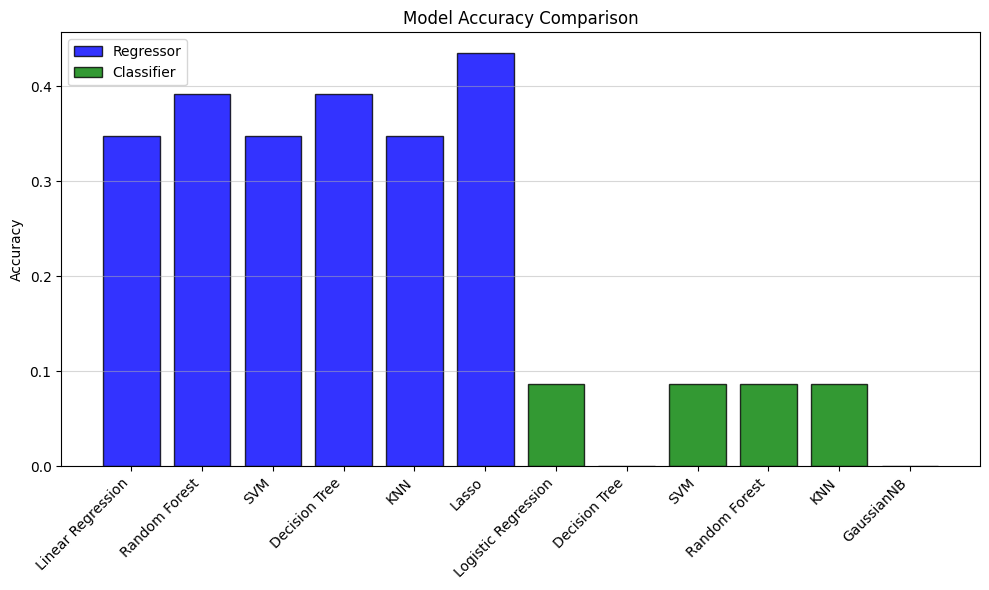

In [26]:
# Combine both DataFrames into one for easier plotting
reg_models_accuracy['type'] = 'Regressor'
cla_models_accuracy['type'] = 'Classifier'
combined_df = pd.concat([reg_models_accuracy, cla_models_accuracy])

x_labels = combined_df['model_name'].values
x_indices = np.arange(len(x_labels))
bar_colors = combined_df['type'].map({'Regressor': 'blue', 'Classifier': 'green'})

plt.figure(figsize=(10, 6))
plt.bar(x_indices, combined_df['accuracy'], color=bar_colors, alpha=0.8, edgecolor='black')

plt.xticks(x_indices, x_labels, rotation=45, ha='right', fontsize=10)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

handles = [
    plt.Rectangle((0, 0), 1, 1, facecolor='blue', alpha=0.8, edgecolor='black', label='Regressor'),
    plt.Rectangle((0, 0), 1, 1, facecolor='green', alpha=0.8, edgecolor='black', label='Classifier')
]
plt.legend(handles=handles, loc='upper left')

plt.grid(axis='y', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

## Save The model

In [27]:
joblib.dump(cla_nb_model, 'trained_model.pkl') # TODO: use the best model dinamically

['trained_model.pkl']